# Bonus Assignment - HW3 Q1
## December 7, 2020
## Anderson Monken

In [1]:
import os
import torch 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
# reference website where I learned the image autoencoder process for pytorch
# https://analyticsindiamag.com/hands-on-guide-to-implement-deep-autoencoder-in-pytorch-for-image-reconstruction/

### Data and Function Setup

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'MNIST_Out_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decod_img(img, epoch):
    img = img.view(img.size(0), 3, 32, 32)
    save_image(img, './MNIST_Out_Images/Autoencoder_image{}.png'.format(epoch))
make_dir()
device = get_device()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)

In [7]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

### Model Construction

In [8]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, 2, stride=2, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, 2, stride=2, padding=1),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU()
        )
        
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
def train(model, train_loader, Epochs):
    """ Sourced from referenced website """
    train_loss = []
    for epoch in range(Epochs):
        running_loss = 0.0
        for data in train_loader:
            img, _ = data
            img = img.to(device)
            optimizer.zero_grad()
            outputs = model(img)
            loss = criterion(outputs, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        loss = running_loss / len(train_loader)
        train_loss.append(loss)
        print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, Epochs, loss))

        if epoch % 5 == 0:
            save_decod_img(outputs.cpu().data, epoch)

    return train_loss

In [10]:
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(128, 64, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(8, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)

In [11]:
# get the summary of model from torchsummary package
# this is easier for me to track the shapes :)
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 17, 17]           1,664
         MaxPool2d-2            [-1, 128, 8, 8]               0
              ReLU-3            [-1, 128, 8, 8]               0
            Conv2d-4             [-1, 64, 5, 5]          32,832
         MaxPool2d-5             [-1, 64, 2, 2]               0
              ReLU-6             [-1, 64, 2, 2]               0
   ConvTranspose2d-7             [-1, 32, 4, 4]          18,464
              ReLU-8             [-1, 32, 4, 4]               0
   ConvTranspose2d-9             [-1, 16, 8, 8]           4,624
             ReLU-10             [-1, 16, 8, 8]               0
  ConvTranspose2d-11            [-1, 8, 16, 16]           1,160
             ReLU-12            [-1, 8, 16, 16]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             219
          Sigmoid-14            [-1, 3,

In [12]:
# add loss and optimizing functions
criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# train the model
max_epochs = 26
outputs = train(model, train_loader, Epochs=max_epochs)

Epoch 1 of 26, Train Loss: 0.386
Epoch 2 of 26, Train Loss: 0.231
Epoch 3 of 26, Train Loss: 0.223
Epoch 4 of 26, Train Loss: 0.218
Epoch 5 of 26, Train Loss: 0.213
Epoch 6 of 26, Train Loss: 0.207
Epoch 7 of 26, Train Loss: 0.203
Epoch 8 of 26, Train Loss: 0.201
Epoch 9 of 26, Train Loss: 0.199
Epoch 10 of 26, Train Loss: 0.197
Epoch 11 of 26, Train Loss: 0.196
Epoch 12 of 26, Train Loss: 0.195
Epoch 13 of 26, Train Loss: 0.194
Epoch 14 of 26, Train Loss: 0.194
Epoch 15 of 26, Train Loss: 0.193
Epoch 16 of 26, Train Loss: 0.192
Epoch 17 of 26, Train Loss: 0.192
Epoch 18 of 26, Train Loss: 0.191
Epoch 19 of 26, Train Loss: 0.191
Epoch 20 of 26, Train Loss: 0.190
Epoch 21 of 26, Train Loss: 0.190
Epoch 22 of 26, Train Loss: 0.189
Epoch 23 of 26, Train Loss: 0.189
Epoch 24 of 26, Train Loss: 0.188
Epoch 25 of 26, Train Loss: 0.188
Epoch 26 of 26, Train Loss: 0.187


### Model Evaluation

In [14]:
imgs = next(iter(train_loader))[0]

In [15]:
imgs_cuda = imgs.to(device)
prediction = model(imgs_cuda)
prediction = prediction.to('cpu')

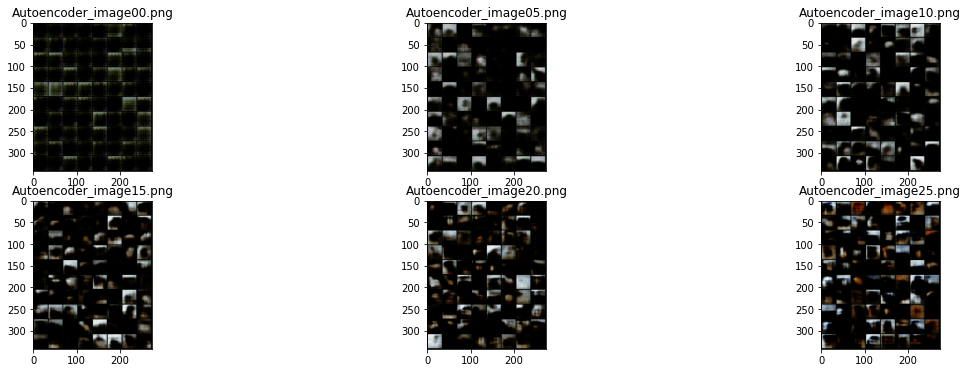

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(20,6))
files = [os.path.join('MNIST_Out_Images',x) for x in sorted(os.listdir('MNIST_Out_Images')) if x.endswith('.png')]
for i,ax in enumerate(axes.flat):
    ax.set_title(files[i].split('/')[1])
    ax.imshow(np.array(Image.open(files[i])))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


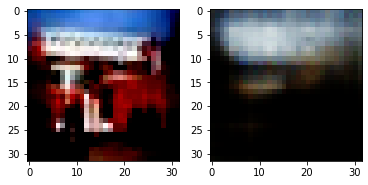

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


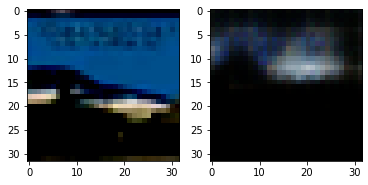

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


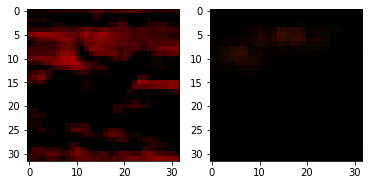

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


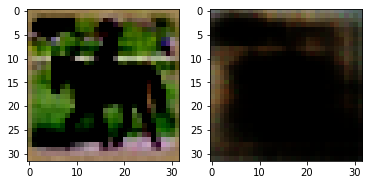

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


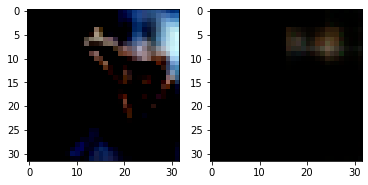

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


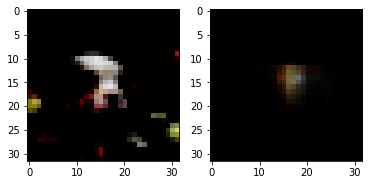

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


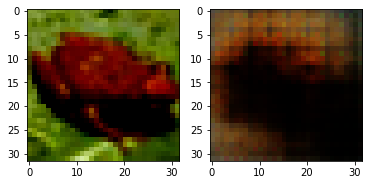

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


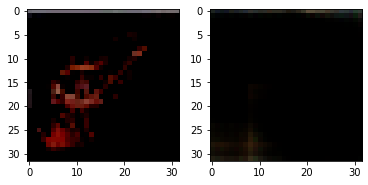

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


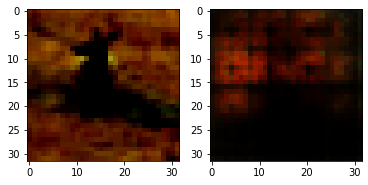

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


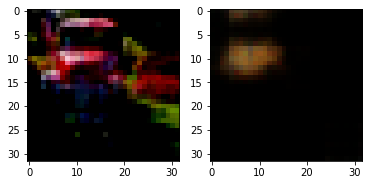

In [17]:
for i in range(10):
  plt.subplot(1, 2, 1)
  plt.imshow(np.moveaxis(imgs[i].numpy().squeeze(),0,-1), cmap = 'bone')
  plt.subplot(1, 2, 2,)
  plt.imshow((np.moveaxis(prediction[i].detach().numpy().squeeze(),0,-1) * 255).astype(np.uint8), cmap = 'bone')
  plt.show()